<a href="https://colab.research.google.com/github/RYU-MCFLY/analyst_survival_public/blob/main/DL_Survival_Convolutional_Neural_Network_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANTE: Antes de iniciar cambiar entorno de ejecución a GPU


# **Redes Neuronales Convolucionales Para Análisis de Supervivencia- SCNN** (de escaneos 3D de Tomografía Computarizada)

In [ ]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy 
from typing import Dict, Iterable, Sequence, Tuple, Optional
import pathlib
from pathlib import Path
!pip install lifelines
from lifelines.utils import concordance_index

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Carga de datos y preprocesamiento**

## Instrucciones para carga de datos a Drive

- Click al siguiente enlace: https://drive.google.com/drive/folders/1kYHhhvDvUGQGgZqLsePJ7Bm9-F1gCFbx?usp=sharing .

- La carpeta "SCNN-Curso" aparecerá en su drive en el apartado "compartido conmigo".

- Dar click derecho a dicha carpeta y selecciona la opción "Añadir acceso directo a Drive".

- La carpeta aparecerá en su Drive y pueden conectarlo directamente con Colab.

# **Escaneos TC**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_folder = pathlib.Path("/content/drive/My Drive/SCNN-curso/x_train/images")
all_image_paths = [str(img_path) for img_path in list(train_folder.glob("*"))]
all_image_paths = sorted(all_image_paths)
images=all_image_paths
len(images)

300

In [ ]:
images

['/content/drive/My Drive/SCNN-curso/x_train/images/patient_002.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_003.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_004.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_005.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_007.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_008.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_011.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_014.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_015.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_016.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_017.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_018.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_020.npz',
 '/content/drive/My Drive/SCNN-curso/x_train/images/patient_021.npz',
 '/content/drive/My 

<center><img src='https://www.revmed.ch/var/site/storage/images/rms-363/images/rms_idpas_d_isbn_pu2012-41s_sa02_art02_img002.jpg/1124845-1-fre-CH/RMS_idPAS_D_ISBN_pu2012-41s_sa02_art02_img002.jpg_i770.jpg' width='500'>

Los escaneos TC contienen voxels de intensidad en la escala de Housfield Units (HU). Esta está definida como Aire = -1000 HU, Pulmón ≈ −500 HU, Agua = 0 HU, Tejido blando (y sangre) ≈ +50 HU, Hueso ≈ +1000 HU.

Una ventana de -1200 a +800 se puede aplicar para ver tumores pulmonares y normalizar los escaneos TC.

<center><img src='https://prod-images-static.radiopaedia.org/images/52608436/ffb5a7e3ebb12255dec689e924ddbd_jumbo.jpeg' width="500" >


Exploremos como sería una de las imágenes



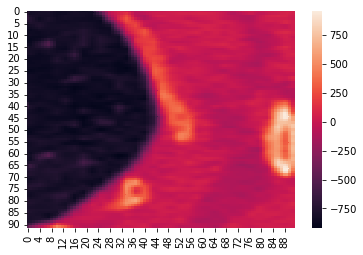

In [ ]:
import seaborn

path_uno = images[0]
path_scan = np.load(path_uno)
path_scan = path_scan['scan']
seaborn.heatmap(path_scan[0])

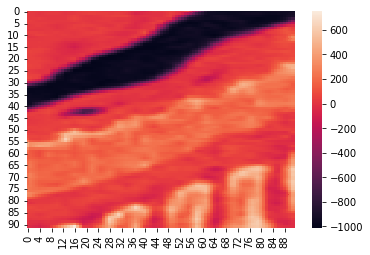

In [ ]:
seaborn.heatmap(path_scan[91])

In [ ]:
def read_file(filepath):
    # Read file
    scan = np.load(filepath)
    # Get raw data
    scan = scan['scan']
    return scan

def normalize(volume):
    min = -1200
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def process_scan(path):
    # Read scan
    volume = read_file(path)
    # Normalize
    volume = normalize(volume)
    return volume

In [ ]:
# Each scan is rescaled.
normal_scans = np.array([process_scan(path) for path in images])
normal_scans.shape

(300, 92, 92, 92)

### **Objetivo (target) y variables censuradas**

In [ ]:
y_train = pd.read_csv('/content/drive/My Drive/SCNN-curso/y_train.csv', index_col=0)
y_train=y_train.sort_index()
y_train

,SurvivalTime,Event
PatientID,,
2,638,0
3,421,0
4,465,1
5,1295,1
7,1393,0
...,...,...
420,528,1
421,1503,0
422,315,0


### **Separando Datos de Entrenamiento y de Validación**

In [ ]:
survivaltime = y_train['SurvivalTime']
event = y_train['Event']

In [ ]:
# Split data in the ratio 260-40 (86-14 aprox.) for training and validation.
x_train = normal_scans[40:]
time_train = np.array(survivaltime[40:])
event_train = np.array(event[40:])

x_test = normal_scans[:40]
time_test = np.array(survivaltime[:40])
event_test = np.array(event[:40])

## **Creación de la Red Neuronal Convolucional para el Análisis de Supervivencia**

### **Datos de Entrenamiento y Validación**

In [ ]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set

### ¿Que hace la función "_make_riskset"?

Compara riesgos entre una población y nos entrega una matriz de valores booleanos con estas comparaciones.

In [ ]:
dummy = np.array([1,4,7,3])

In [ ]:
_make_riskset(dummy)

array([[ True,  True,  True,  True],
       [False,  True,  True, False],
       [False, False,  True, False],
       [False,  True,  True,  True]])

In [ ]:
class InputFunction_train:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 20,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 89) -> None:



        if images.ndim == 4:
            images = images[..., np.newaxis]
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch."""

        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        """ Data augmentation techniques from DLTK library
        -------
        # Randomly flip the image along axis 1
        images = flip(images.copy(), axis=1)
        # Add a Gaussian offset 
        images = add_gaussian_offset(images.copy(), sigma=0.5)
        # Add Gaussian noise
        images = add_gaussian_noise(images.copy(), sigma=0.15)
        """

        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`."""
        batch_size = self.batch_size if self.drop_last else None
        h, w, d, c = self.images.shape[1:]
        images = tf.TensorShape([batch_size, h, w, d, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()

class InputFunction_test:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 20,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 89) -> None:
        if images.ndim == 4:
            images = images[..., np.newaxis]
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch."""
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`."""
        batch_size = self.batch_size if self.drop_last else None
        h, w, d, c = self.images.shape[1:]
        images = tf.TensorShape([batch_size, h, w, d, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()

def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true."""
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.math.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.math.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output

### **Cálculo de la functión de perdida COX PH**

In [ ]:
class CoxPHLoss(tf.keras.losses.Loss):
    """Negative partial log-likelihood of Cox's proportional hazards model."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)            

    def __call__(self,
             y_true: Sequence[tf.Tensor],
             y_pred: tf.Tensor) -> tf.Tensor:
        """Compute loss.

        Parameters
        ----------
        y_true : list|tuple of tf.Tensor
            The first element holds a binary vector where 1
            indicates an event 0 censoring.
            The second element holds the riskset, a
            boolean matrix where the `i`-th row denotes the
            risk set of the `i`-th instance, i.e. the indices `j`
            for which the observer time `y_j >= y_i`.
            Both must be rank 2 tensors.
        y_pred : tf.Tensor
            The predicted outputs. Must be a rank 2 tensor.

        Returns
        -------
        loss : tf.Tensor
            Loss for each instance in the batch.
        """
        event, riskset = y_true
        predictions = y_pred

        pred_shape = predictions.shape
        if pred_shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "be 2." % pred_shape.ndims)

        if pred_shape[1] is None:
            raise ValueError("Last dimension of predictions must be known.")

        if pred_shape[1] != 1:
            raise ValueError("Dimension mismatch: Last dimension of predictions "
                             "(received %s) must be 1." % pred_shape[1])

        if event.shape.ndims != pred_shape.ndims:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "equal rank of event (received %s)" % (
                pred_shape.ndims, event.shape.ndims))

        if riskset.shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                             "be 2." % riskset.shape.ndims)

        event = tf.cast(event, predictions.dtype)
        predictions = safe_normalize(predictions)

        with tf.name_scope("assertions"):
            assertions = (
                tf.debugging.assert_less_equal(event, 1.),
                tf.debugging.assert_greater_equal(event, 0.),
                tf.debugging.assert_type(riskset, tf.bool)
            )

        # move batch dimension to the end so predictions get broadcast
        # row-wise when multiplying by riskset
        pred_t = tf.transpose(predictions)
        # compute log of sum over risk set for each row
        rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
        assert rr.shape.as_list() == predictions.shape.as_list()

        losses = tf.math.multiply(event, rr - predictions)

        return losses

### **Cálculo del índice de Concordancia (Concordance Index)** (en los datos de validación, en cada época)

#### Como funciona el índice: Relaciona tiempos con riesgos predichos y compara su orden.




In [ ]:
concordance_index([1,2,3,4,5],[10,20,50,60,90])

1.0

In [ ]:
concordance_index([1,2,3,4,5],[55,32,27,22,3])

0.0

In [ ]:
concordance_index([1,2,3,4,5],[22,31,47,52,9])

0.6

In [ ]:
class CindexMetric:
    """Computes concordance index across one epoch."""

    def reset_states(self) -> None:
        """Clear the buffer of collected values."""
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }

    def update_state(self, y_true: Dict[str, tf.Tensor], y_pred: tf.Tensor) -> None:
        """Collect observed time, event indicator and predictions for a batch.

        Parameters
        ----------
        y_true : dict
            Must have two items:
            `label_time`, a tensor containing observed time for one batch,
            and `label_event`, a tensor containing event indicator for one batch.
        y_pred : tf.Tensor
            Tensor containing predicted risk score for one batch.
        """
        self._data["label_time"].append(y_true["label_time"].numpy())
        self._data["label_event"].append(y_true["label_event"].numpy())
        self._data["prediction"].append(tf.squeeze(y_pred).numpy())

    def result(self) -> Dict[str, float]:
        """Computes the concordance index across collected values.

        Returns
        ----------
        metrics : dict
            Computed metrics.
        """
        data = {}
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        results = concordance_index(
            data["label_time"],
            data["prediction"],
            data["label_event"] == 1,)

        result_data = {}
        names = "cindex"
        result_data[names] = 1-results

        return result_data

### **Entrenamiento de la SCNN**

In [ ]:
import tensorflow.compat.v2.summary as summary
from tensorflow.python.ops import summary_ops_v2

class TrainAndEvaluateModel:

    def __init__(self, model, model_dir, train_dataset, eval_dataset,
                 learning_rate, num_epochs):
        """ Note: 'train_dataset' to be removed from __init__ if  
        data augmentation is applied """

        self.num_epochs = num_epochs
        self.model_dir = model_dir

        self.model = model

        """ Note: the line below has to be removed if data augmentation is 
        applied """
        self.train_ds = train_dataset

        self.val_ds = eval_dataset

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = CoxPHLoss()

        self.train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
        self.val_cindex_metric = CindexMetric()

    @tf.function
    def train_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)

            train_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=logits)

        with tf.name_scope("gradients"):
            grads = tape.gradient(train_loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return train_loss, logits

    def train_and_evaluate(self):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=self.optimizer,
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        train_summary_writer = summary.create_file_writer(
            str(self.model_dir / "train"))
        val_summary_writer = summary.create_file_writer(
            str(self.model_dir / "valid"))

        for epoch in range(self.num_epochs):
            with train_summary_writer.as_default():
                self.train_one_epoch(ckpt.step)

            # Run a validation loop at the end of each epoch.
            with val_summary_writer.as_default():
                self.evaluate(ckpt.step)

        save_path = ckpt_manager.save()
        print(f"Saved checkpoint for step {ckpt.step.numpy()}: {save_path}")

    def train_one_epoch(self, step_counter):
          """ Note: the two lines below have to be used if data augmentation
              is applied:
          
              data = InputFunction_train(x_train, time_train, event_train, batch_size=10, shuffle=True, drop_last=True)
              for x, y in data():
                        
              Image preprocessing (can be used for data augmentation)
              -------
              #Adjust the brightness of images by a random factor.
              x = tf.image.random_brightness(x, max_delta=63)
              #Adjust the contrast of images by a random factor.
              x = tf.image.random_contrast(x, 0.2, 1.8).
         """

          for x, y in self.train_ds:
            train_loss, logits = self.train_one_step(
                x, y["label_event"], y["label_riskset"])

            step = int(step_counter)
 
            # Update training metric.
            self.train_loss_metric.update_state(train_loss)

            # Log every certain number of batches.
            if step % 5 == 0:
                # Display metrics
                mean_loss = self.train_loss_metric.result()
                print(f"step {step}: mean loss = {mean_loss:.4f}")
                # save summaries
                summary.scalar("loss", mean_loss, step=step_counter)
                # Reset training metrics
                self.train_loss_metric.reset_states()

            step_counter.assign_add(1)
            
    @tf.function
    def evaluate_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        val_logits = self.model(x, training=False)
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
        return val_loss, val_logits

    def evaluate(self, step_counter):
        self.val_cindex_metric.reset_states()
        
        for x_val, y_val in self.val_ds:
            val_loss, val_logits = self.evaluate_one_step(
                x_val, y_val["label_event"], y_val["label_riskset"])

            # Update val metrics
            self.val_loss_metric.update_state(val_loss)
            self.val_cindex_metric.update_state(y_val, val_logits)

        val_loss = self.val_loss_metric.result()
        summary.scalar("loss",
                       val_loss,
                       step=step_counter)
        self.val_loss_metric.reset_states()
        
        val_cindex = self.val_cindex_metric.result()
        for key, value in val_cindex.items():
          summary.scalar(key, value, step=step_counter)

        print(f"Validation: loss = {val_loss:.4f}, cindex = {val_cindex['cindex']:.4f}")

### **Arquitectura de la SCNN**

- El tamaño de los escaneos TC (en escala de grises) es 92x92x92. Se normalizan por lotes antes de alimentar la red neuronal.
- Dos capas convolucionales usando un kernel de tamaño 3x3x3, stride=1, padding='valid', función ReLu como función de activación, seguido de una normalización por lotes (BatchNormalization) y una capa de MaxPooling con tamaño de pool 2, dividiendo la dimensión espacial en un tamaño de 2.
- Red totalmente conectada, compuesta de dos capas ocultas densas y una capa de salida densa. Una normalización por lotes es aplicada a la salida de las 2 capas densas ocultas. La capa final entrega como salida las predicciones (risk score). Una capa de abandono (dropout) con abandono del 10% se agrega para evitar el sobreajuste (overfitting).


In [ ]:
model = tf.keras.Sequential([
                             
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv3D(filters=16, kernel_size=(3,3,3), activation="relu", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)),

    tf.keras.layers.Conv3D(filters=32, kernel_size=(3,3,3), activation="relu", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu', name='dense_1', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(84, activation='relu', name='dense_2', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.10),
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')

])

*Nota: Cambios que podrían hacerse:
- Capas CONV3D y Densas adicionales
- Filtros adicionales en las capas CONV3D
- Capas de normalizacion de lotes antes de las funciones de activación
- Técnicas de regularización para evitar sobreajuste:
  - Mas alto porcentaje de Abandono 
  - Capas de Abandono antes de cada capa CONV3D
  - Regularización L1/L2
  - Aumento de Datos (Data Augmentation) por:
    - Voltear al azar los escaneos TC
    - Añadir ruido Gaussiano a los escaneos TC
    - Rotar al azar los escaneos TC
    - Ajustar al azar el brillo y contraste de los escaneos TC

Ninguna de estas proporcionó mejores resultados.

In [ ]:
""" Note: The line below has to be removed if data augmentation is applied. """
train_fn = InputFunction_train(x_train, time_train, event_train, batch_size=20, shuffle=True, drop_last=True)

eval_fn = InputFunction_test(x_test, time_test, event_test)

trainer = TrainAndEvaluateModel(
    model=model,
    # Note: The line below has to be removed if data augmentation is applied.
    train_dataset=train_fn(),
    model_dir=Path("/content/drive/My Drive/SCNN-curso/ckpts-mnist-cnn"),
    eval_dataset=eval_fn(),
    learning_rate=0.01,
    num_epochs=1,
)

In [ ]:
trainer.train_and_evaluate()

Latest checkpoint restored from /content/drive/My Drive/SCNN-curso/ckpts-mnist-cnn/ckpt-6.
step 780: mean loss = 0.3559
step 785: mean loss = 0.7624
step 790: mean loss = 0.6118
Validation: loss = 2.1120, cindex = 0.4927
Saved checkpoint for step 793: /content/drive/My Drive/SCNN-curso/ckpts-mnist-cnn/ckpt-7


## **Resultados**

### **Puntuación de Riesgo (risk score) Predicha**

In [ ]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(alpha=0.05)

class Predictor:

    def __init__(self, model, model_dir):
        self.model = model
        self.model_dir = model_dir

    def predict(self, dataset):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=tf.keras.optimizers.Adam(),
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        risk_scores = []
        for batch in dataset:
            pred = self.model(batch, training=False)
            risk_scores.append(pred.numpy())

        return np.row_stack(risk_scores)

**En Datos de Entrenamiento**

In [ ]:
train_pred_fn = tf.data.Dataset.from_tensor_slices(x_train[..., np.newaxis]).batch(20)

predictor = Predictor(model, trainer.model_dir)

In [ ]:
#Predicted risk score of train data
train_predictions = predictor.predict(train_pred_fn)

risk_score_train=pd.DataFrame(train_predictions)
risk_score_train['time_train']=time_train
risk_score_train['event_train']=event_train
risk_score_train=risk_score_train.rename(columns={0:'risk_score'})
risk_score_train.head()

Latest checkpoint restored from /content/drive/My Drive/SCNN-curso/ckpts-mnist-cnn/ckpt-7.


,risk_score,time_train,event_train
0,-4.554398,3259,0
1,-4.687880,754,0
2,-2.473387,754,1
3,-3.140783,1315,0
4,1.415363,76,1


**En Datos de Validación**

In [ ]:
#Predicted risk score of validation data
sample_pred_ds = tf.data.Dataset.from_tensor_slices(x_test[..., np.newaxis]).batch(20)
sample_predictions = predictor.predict(sample_pred_ds)

risk_score_val=pd.DataFrame(sample_predictions)
risk_score_val['time_test']=time_test
risk_score_val['event_test']=event_test
risk_score_val=risk_score_val.rename(columns={0:'risk_score'})

Latest checkpoint restored from /content/drive/My Drive/SCNN-curso/ckpts-mnist-cnn/ckpt-6.


In [ ]:
risk_score_val.head()

,risk_score,time_test,event_test
0,7.831461,638,0
1,-5.231787,421,0
2,-4.242494,465,1
3,7.451314,1295,1
4,8.742767,1393,0


### **Modelo de Cox Univariado** 

Usando la puntuación de risgo como variable explicativa

In [ ]:
breslow = cph.fit(risk_score_train, duration_col="time_train", event_col="event_train")
breslow.print_summary()

<lifelines.CoxPHFitter: fitted with 260 total observations, 119 right-censored observations>
             duration col = 'time_train'
                event col = 'event_train'
      baseline estimation = breslow
   number of observations = 260
number of events observed = 141
   partial log-likelihood = -546.77
         time fit was run = 2022-11-24 00:10:39 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
risk_score   0.61       1.85       0.04             0.53             0.69                 1.70                 2.00

             cmp to     z      p   -log2(p)
covariate                                  
risk_score     0.00 15.01 <0.005     166.72
---
Concordance = 0.90
Partial AIC = 1095.54
log-likelihood ratio test = 325.21 on 1 df
-log2(p) of ll-ratio test = 239.09

### **Modelo de Cox Multivariado** 

Con el riesgo predicho y las variables clinicas significativas como la base del modelo

**En Datos de Entrenamiento**

In [ ]:
clinical_train=pd.read_csv("/content/drive/MyDrive/SCNN-curso/x_train/features/clinical_data.csv", index_col='PatientID')

#Preprocessing
categories = ['Nstage']
clinical_train = pd.get_dummies(clinical_train, columns=categories, drop_first=True)
clinical_train=clinical_train.drop(columns=['Histology','Mstage','Tstage'])
clinical_train=clinical_train.sort_index()
clinical_train=clinical_train.iloc[40:,:]
clinical_train=clinical_train.reset_index()
clinical_train['predictions']=train_predictions
clinical_train['time_train']=risk_score_train.time_train
clinical_train['event_train']=risk_score_train.event_train
clinical_train.SourceDataset=clinical_train.SourceDataset.apply(lambda x: 0 if x=='l1' else 1)

from sklearn.impute import SimpleImputer # to impute/replace the numerical or categorical missing data related to one or more features with appropriate values

imp_mean = SimpleImputer(strategy='median')
clinical_train_= imp_mean.fit_transform(clinical_train)
clinical_train=pd.DataFrame(clinical_train_, index=clinical_train.index, columns=clinical_train.columns)
clinical_train=clinical_train.drop(columns=['PatientID'])
clinical_train.head()

,SourceDataset,age,Nstage_1,Nstage_2,Nstage_3,predictions,time_train,event_train
0,1.0,62.0000,0.0,0.0,0.0,-4.554398,3259.0,0.0
1,0.0,70.2368,0.0,0.0,1.0,-4.687880,754.0,0.0
2,0.0,65.1143,0.0,0.0,0.0,-2.473387,754.0,1.0
3,0.0,60.4709,0.0,0.0,0.0,-3.140783,1315.0,0.0
4,0.0,70.0000,0.0,0.0,1.0,1.415363,76.0,1.0


In [ ]:
breslow = cph.fit(clinical_train, duration_col="time_train", event_col="event_train")
breslow.print_summary()

<lifelines.CoxPHFitter: fitted with 260 total observations, 119 right-censored observations>
             duration col = 'time_train'
                event col = 'event_train'
      baseline estimation = breslow
   number of observations = 260
number of events observed = 141
   partial log-likelihood = -541.47
         time fit was run = 2022-11-24 00:23:09 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
SourceDataset  -0.46       0.63       0.25            -0.96             0.03                 0.38                 1.03
age             0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
Nstage_1        0.27       1.31       0.37            -0.45             0.98                 0.64                 2.67
Nstage_2       -0.14       0.87       0.22            -0.56             0.29                 0.57                 1.33
Nstage_3        0.41       1.51       0.28            -0.13             0.96                 0.88                 2.61
predictions     0.61       1.85       0.04             0.53             0.70                 1.70                 2.01

                cmp to     z      p   -log2(p)
covariate                                     
SourceDataset     0.00 -1.83   0.07       3.89
age               0.00  1.40   0.16       2.64
Nstage_1          0.00  0.73   0.47       1.10
Nstage_2          0.00 -0.64   0.52       0.94
Nstage_3          0.00  1.49   0.14       2.87
predictions       0.00 14.17 <0.005     149.07
---
Concordance = 0.90
Partial AIC = 1094.94
log-likelihood ratio test = 335.80 on 6 df
-log2(p) of ll-ratio test = 228.43

**En Datos de Validación**

In [ ]:
clinical_test=pd.read_csv("/content/drive/My Drive/SCNN-curso/x_train/features/clinical_data_train.csv", index_col='PatientID')

#Preprocessing
clinical_test['Nstage']=clinical_test.Nstage.apply(lambda x: 3 if x==4 else x)
categories = ['Nstage']
clinical_test = pd.get_dummies(clinical_test, columns=categories, drop_first=True)
clinical_test=clinical_test.drop(columns=['Histology','Mstage', 'Tstage'])
clinical_test=clinical_test.sort_index()
clinical_test=clinical_test.iloc[:40,:]
clinical_test=clinical_test.reset_index()
clinical_test['predictions']=sample_predictions
clinical_test['time_test']=risk_score_val.time_test
clinical_test['event_test']=risk_score_val.event_test
clinical_test.SourceDataset=clinical_test.SourceDataset.apply(lambda x: 0 if x=='l1' else 1)

clinical_test_= imp_mean.transform(clinical_test)
clinical_test=pd.DataFrame(clinical_test_, index=clinical_test.index, columns=clinical_test.columns)
clinical_test=clinical_test.drop(columns=['PatientID'])
clinical_test.head()

ValueError: ignored

In [ ]:
# Expected Lifetime
clinical_test['predictions']=breslow.predict_expectation(clinical_test)

#Concordance Index
print(f'Concordance index (lifelines): {concordance_index(clinical_test.time_test, clinical_test.predictions, clinical_test.event_test)}')

Concordance index (lifelines): 0.5604395604395604


### **Predicciones de Tiempo de Vida Esperado en los datos de Test**

In [ ]:
# Loading Data
test_folder = pathlib.Path("/content/drive/My Drive/SCNN-curso/x_test/images")
all_image_paths_test = [str(img_path) for img_path in list(test_folder.glob("*"))]
all_image_paths_test = sorted(all_image_paths_test)
normal_scans_test = np.array([process_scan(path) for path in all_image_paths_test])

#Predicted risk score of validation data
sample_pred_ds = tf.data.Dataset.from_tensor_slices(normal_scans_test[..., np.newaxis]).batch(20)
sample_predictions = predictor.predict(sample_pred_ds)

Latest checkpoint restored from /content/drive/My Drive/SCNN-curso/ckpts-mnist-cnn/ckpt-7.


In [ ]:
# Preprocessing
clinical_test=pd.read_csv("/content/drive/My Drive/SCNN-curso/x_test/features/clinical_data.csv", index_col='PatientID')
clinical_test['Nstage']=clinical_test.Nstage.apply(lambda x: 3 if x==4 else x)
categories = ['Nstage']
clinical_test = pd.get_dummies(clinical_test, columns=categories, drop_first=True)
clinical_test=clinical_test.drop(columns=['Histology','Mstage','Tstage'])
clinical_test=clinical_test.sort_index()
clinical_test=clinical_test.reset_index()
clinical_test['predictions']=sample_predictions
clinical_test['time_train']=1
clinical_test['event_train']=2
clinical_test.SourceDataset=clinical_test.SourceDataset.apply(lambda x: 0 if x=='l1' else 1)

clinical_test_= imp_mean.transform(clinical_test)
clinical_test=pd.DataFrame(clinical_test_, index=clinical_test.index, columns=clinical_test.columns)
clinical_test=clinical_test.drop(columns=['PatientID','time_train','event_train'])
clinical_test.head()

,SourceDataset,age,Nstage_1,Nstage_2,Nstage_3,predictions
0,1.0,78.0000,0.0,0.0,0.0,0.630988
1,0.0,71.7153,0.0,1.0,0.0,0.293498
2,0.0,64.1615,0.0,1.0,0.0,-0.943514
3,1.0,50.0000,0.0,0.0,0.0,-2.081317
4,0.0,80.4819,0.0,1.0,0.0,1.534428


In [ ]:
# Expected Lifetime
pred=breslow.predict_expectation(clinical_test)

In [ ]:
output=pd.DataFrame(data=pred)
output=output.rename(columns={0:'SurvivalTime'})
output['Event']='nan'
output.head(15)

,SurvivalTime,Event
0,726.413095,nan
1,712.950429,nan
2,1251.739584,nan
3,2330.158389,nan
4,424.505146,nan
5,1692.183944,nan
6,2044.120324,nan
7,1599.433554,nan
8,460.126381,nan
9,3389.380233,nan


**Resultado Final**

In [ ]:
final = pd.read_csv("/content/drive/MyDrive/SCNN-curso/x_test/features/clinical_data.csv")
final = pd.concat([final, output], axis=1)
final.drop(columns=['Histology', 'Nstage', 'Mstage', 'SourceDataset', 'Tstage', 'age'], inplace=True)
final.head(15)

,PatientID,SurvivalTime,Event
0,13,726.413095,nan
1,155,712.950429,nan
2,404,1251.739584,nan
3,407,2330.158389,nan
4,9,424.505146,nan
5,49,1692.183944,nan
6,55,2044.120324,nan
7,200,1599.433554,nan
8,170,460.126381,nan
9,387,3389.380233,nan
